In [1]:
import numpy as np
import numpy.random as rnd
import tensorflow as tf
print(tf.__version__)
import tensorflow_probability as tfp
import gpflow
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
%matplotlib inline
plt.style.use('ggplot')

1.15.0-rc2


In [2]:
data = np.load('../data/uav_data1.npz')
X = data['x']
Y = data['y']

In [3]:
def plot_contour(ax, x, y, z, a=None, contour=None, inputs=False):
    x = x * X.std() + X.mean()
    y = y * X.std() + X.mean()

    surf = ax.contourf(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    cont = None
    if contour is not None and a is not None:
        cont = ax.contour(x, y, a, levels=contour)
    if contour is not None and a is None:
        cont = ax.contour(x, y, z, levels=contour)
    if inputs is True:
        # plt.plot(x.flatten(), y.flatten(), 'xk')
        plt.plot(X_[:, 0], X_[:, 1], 'xk')
    return surf, cont

def plot_contourf(x, y, z, a=None, contour=None, title=None, inputs=False, save_name=None):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.gca()
    surf, cont = plot_contour(ax, x, y, z, a, contour, inputs=inputs)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    if save_name is not None:
        plt.savefig(save_name, transparent=True, bbox_inches='tight')
    plt.show()

def plot_contourf_var(x, y, z, z_var, a=None, contour=None, title=None, inputs=False, save_name=None):
    # fig, axs = plt.subplot(2, sharex=True, sharey=True)
    fig, axs = plt.subplots(1, 2,figsize=(24, 4))
    plt.subplots_adjust(wspace=0, hspace=0)

    surf_mu, cont_mu = plot_contour(axs[0], x, y, z, a, contour, inputs)
    cbar = fig.colorbar(surf_mu, shrink=0.5, aspect=5, ax=axs[0])
    cbar.set_label('mean')
    surf_var, cont_var = plot_contour(axs[1], x, y, z_var, a, contour, inputs)
    cbar = fig.colorbar(surf_var, shrink=0.5, aspect=5, ax=axs[1])
    cbar.set_label('variance')

    plt.suptitle(title)
    if save_name is not None:
        plt.savefig(save_name, transparent=True, bbox_inches='tight')
    plt.show()

In [4]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []

    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

In [5]:
from gpflow.training import monitor as mon
def run_adam(model, maxiter=450):
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=maxiter)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

def plot_loss(logger):
    plt.plot(-np.array(logger.logf))
    plt.xlabel('iteration (x10)')
    plt.ylabel('ELBO');

In [19]:
def plot_model2D_uav(m, f=False, a=False, a_true=None, h=False, y=False, y_true=False, y_a=None, inputs=False, var=False, save_name=None):
    N = 100
    # make grid for predicitons
    x1_high = m.X.value[:, 0].max()
    x2_high = m.X.value[:, 1].max()
    x1_low = m.X.value[:, 0].min()
    x2_low = m.X.value[:, 1].min()

    xx, yy = np.mgrid[x1_low:x1_high:N*1j, x2_low:x2_high:N*1j]
    # Need an (N, 2) array of (x, y) pairs.
    xy = np.column_stack([xx.flat, yy.flat])

    if a is True:
        a_mu, a_var = m.predict_a(xy)  # Predict alpha values at test locations
        # plot_contourf_var(xx, yy, a_mu.reshape(xx.shape), a_var.reshape(xx.shape), contour=[0.5], title='predicted alpha', inputs=inputs, save_name="img/learned_alpha"+save_name+".pdf")
        plot_contourf_var(xx, yy, a_mu.reshape(xx.shape), a_var.reshape(xx.shape), contour=[0.5], title='predicted alpha', inputs=inputs)

    if a_true is not None:
        plot_contourf(mx, my, a_true.reshape(xx.shape), contour=[0.5], title='Original alpha', inputs=inputs, save_name="img/original_alpha"+save_name+".pdf")

    if f is True:
        f_mus, f_vars = m.predict_f(xy)  # Predict alpha values at test locations
        for i, (f_mu, f_var) in enumerate(zip(f_mus, f_vars)):
            plot_contourf_var(xx, yy, f_mu[:, 0].reshape(xx.shape), f_var[:, 0].reshape(xx.shape), title=('predicted $f_%i$ dim 1' % i), inputs=inputs)
            plot_contourf_var(xx, yy, f_mu[:, 1].reshape(xx.shape), f_var[:, 1].reshape(xx.shape), title=('predicted $f_%i$ dim 2' % i), inputs=inputs)

    if y is True:
        y_mu, y_var = m.predict_y(xy)  # Predict alpha values at test locations
        print(y_mu.shape)
        if y_a is not None:
            plot_contourf_var(xx, yy, y_mu[:, 0].reshape(xx.shape), y_var[:, 0].reshape(xx.shape), title='predicted y dim 1', inputs=inputs)
            plot_contourf_var(xx, yy, y_mu[:, 1].reshape(xx.shape), y_var[:, 1].reshape(xx.shape), title='predicted y dim 2', inputs=inputs)
        else:
            plot_contourf_var(xx, yy, y_mu[:, 0].reshape(xx.shape), y_var[:, 0].reshape(xx.shape), title='predicted y dim 1', inputs=inputs)
            plot_contourf_var(xx, yy, y_mu[:, 1].reshape(xx.shape), y_var[:, 1].reshape(xx.shape), title='predicted y dim 2', inputs=inputs)
            # plot_contourf(xx, yy, y_mu.reshape(xx.shape), y_var.reshape(xx.shape), title='predicted y', inputs=inputs)
            # TODO: how to plot variance of GPs??

    if y_true is True:
        if y_a is not None:
            plot_contourf(mx, my, mz1, a=y_a.reshape(mx.shape), contour=[0.5], title='original y dim 1', inputs=inputs)
            plot_contourf(mx, my, mz2, a=y_a.reshape(mx.shape), contour=[0.5], title='original y dim 2', inputs=inputs)
        else:
            plot_contourf(mx, my, mz1, title='original y dim 1', inputs=inputs)
            plot_contourf(mx, my, mz2, title='original y dim 2', inputs=inputs)

    if var is True:
        lik_var, f_var = m.predict_vars(xy)
        plot_contourf_var(xx, yy, lik_var.reshape(xx.shape), f_var.reshape(xx.shape), title='noise variance vs GP covariance', inputs=inputs)
# plot_model2D_uav(m, a=True)
# print(m.X.value[:, 0].max())

In [7]:
from gpflow import kullback_leiblers, settings, transforms, features
from gpflow.conditionals import conditional, Kuu
from gpflow.decors import params_as_tensors
from gpflow.models.model import GPModel
from gpflow.params import DataHolder, Minibatch, Parameter, ParamList
from gpflow.mean_functions import Zero
from gpflow.models.model import Model
from gpflow.decors import params_as_tensors, autoflow
from gpflow.quadrature import ndiagquad
from gpflow.multioutput import kernels as mk
from gpflow.multioutput import features as mf

float_type = gpflow.settings.float_type

In [8]:
from gpflow.likelihoods import Likelihood, SwitchedLikelihood, Gaussian, Bernoulli

def inv_probit(x):
    jitter = 1e-3  # ensures output is strictly between 0 and 1
    return 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter


class BernoulliGaussian(Likelihood):
    def __init__(self, variance_low=np.array([[0.005, 0.], [0., 0.005]]), variance_high=np.array([[0.3, 0.], [0., 0.3]]), invlink=inv_probit, **kwargs):
        super().__init__(**kwargs)
        self.invlink = invlink
        variance_low = Parameter(
            variance_low, transform=transforms.positive, dtype=settings.float_type)
        variance_high = Parameter(
            variance_high, transform=transforms.positive, dtype=settings.float_type)

        variances = [variance_low, variance_high]
        self.variances = ParamList(variances)
        self.likelihood_bern = Bernoulli()
#         self.variance_low.trainable = False
#         self.variance_high.trainable = False

    @params_as_tensors
    def predict_mean_and_var(self, Fmu, Fvar, idx):
        if self.variances[0].shape[1] == 1:
            return tf.identity(Fmu), Fvar + tf.squeeze(self.variances[idx])
        else:
            return tf.identity(Fmu), Fvar + tf.diag_part(tf.squeeze(self.variances[idx]))

    @params_as_tensors
    def predict_mean_and_var_a(self, Hmu, Hvar):
        return self.likelihood_bern.predict_mean_and_var(Hmu, Hvar)

    @params_as_tensors
    def predict_mean_a(self, H):
        return inv_probit(H)

In [9]:
class BMNSVGP(Model):

    def __init__(self, X, Y, var_low, var_high, minibatch_size=None):
        """
        - X is a data matrix, size N x D
        - Y is a data matrix, size N x P
        """
        Model.__init__(self, name="BMNSVGP")
        if minibatch_size is not None:
            self.X = Minibatch(X, batch_size=minibatch_size, seed=0)
            self.Y = Minibatch(Y, batch_size=minibatch_size, seed=0)
        else:
            self.X = Dataholder(X)
            self.Y = Dataholder(Y)

        self.num_data = X.shape[0]
        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        self.whiten = True
        # self.whiten = False
#         num_inducing = len(self.feature)

        # init separation GP
        self.mean_function_h = Zero(output_dim=1)
        self.kern_h = gpflow.kernels.RBF(input_dim=self.input_dim, ARD=True)
        feat = None
        M = 50
        idx = np.random.choice(range(self.num_data), size=M, replace=False)
        Z = X[idx, ...].reshape(-1, self.input_dim)
        self.feature_h = features.inducingpoint_wrapper(feat, Z)
        self.feature_h.trainable = False
        # init variational parameters
        # TODO: auto select number of inducing points
        q_mu_h = np.zeros((M, 1)) + rnd.randn(M, 1)
        q_sqrt_h = np.array([10*np.eye(M, dtype=settings.float_type) for _ in range(1)])
        self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=M, num_latent=1, q_mu=q_mu_h, q_sqrt=q_sqrt_h)
        #         self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=50, num_latent=1)

        # init 2 dynamics GPs for each output dimension
        kernels, mean_functions, feat_list, q_mus, q_sqrts = [], [], [], [], []

        # init dynamics GPs for each mode
        # TODO: change 2 to the number of dynamics GPs
        for i in range(2):
            # init mean functions
            mean_functions.append(Zero(output_dim=self.output_dim))

            # Create list of kernels for each output
            kern_list = [gpflow.kernels.RBF(self.input_dim, ARD=True) for _ in range(self.output_dim)]
            # Create multioutput kernel from kernel list
            kern = mk.SeparateIndependentMok(kern_list)
            kernels.append(kern)

            # initialisation of inducing input locations, one set of locations per output
            Zs = [X[np.random.permutation(len(X))[:M],...].copy() for _ in range(self.output_dim)]
            # initialise as list inducing features
            feature_list = [gpflow.features.InducingPoints(Z) for Z in Zs]
            # create multioutput features from feature_list
            feature = mf.SeparateIndependentMof(feature_list)
            feature.trainable = False
            feat_list.append(feature)

            # init variational inducing points
            q_mu, q_sqrt = self._init_variational_parameters(num_inducing=M, num_latent=self.output_dim)
            # q_mu = np.zeros((M, 1)) + rnd.randn(M, 1)
            # q_sqrt = np.array([10*np.eye(M, dtype=settings.float_type) for _ in range(1)])
            q_mus.append(q_mu)
            q_sqrts.append(q_sqrt)

        self.kernels = ParamList(kernels)
        self.features = ParamList(feat_list)
        self.mean_functions = ParamList(mean_functions)
        self.q_mus = ParamList(q_mus)
        self.q_sqrts = ParamList(q_sqrts)

        # init likelihood
        self.likelihood = BernoulliGaussian(variance_low=var_low, variance_high=var_high)

    def _init_variational_parameters(self, num_inducing, num_latent, q_mu=None, q_sqrt=None, q_diag=None):
        q_mu = np.zeros((num_inducing, num_latent)) if q_mu is None else q_mu
        q_mu = Parameter(q_mu, dtype=settings.float_type)  # M x P

        if q_sqrt is None:
            if q_diag:
                q_sqrt = Parameter(np.ones((num_inducing, num_latent), dtype=settings.float_type),
                                        transform=transforms.positive)  # M x P
            else:
                q_sqrt = np.array([np.eye(num_inducing, dtype=settings.float_type) for _ in range(num_latent)])
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # P x M x M
        else:
            if q_diag:
                assert q_sqrt.ndim == 2
                num_latent = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.positive)  # M x L/P
            else:
                assert q_sqrt.ndim == 3
                num_latent = q_sqrt.shape[0]
                num_inducing = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # L/P x M x M
        return q_mu, q_sqrt

    @params_as_tensors
    def build_prior_KL(self, feature, kern, q_mu, q_sqrt):
        if self.whiten:
            K = None
        else:
            K = Kuu(feature, kern, jitter=settings.numerics.jitter_level)  # (P x) x M x M

        return kullback_leiblers.gauss_kl(q_mu, q_sqrt, K)

    @params_as_tensors
    def _sample_e_h(self, dist_h, f_means, num_samples=1000):
        """
        Calculates variational expectation under separation GP using Gibbs sampling.
        \E_{q(h_n)} [log( p(y_n | f_n, \alpha_n) p(\alpha_n | h_n) )], where,
        q(h_n) = \mathcal{N} (h_n^{(1)}|K_{nm}^{(1)}K_{mn}^{(1)}^{-1}U^{(1)}, \tilde{K}^{(1)})
            dist_h: conditional gaussian dist p(h_n | U_h, x_n) ~ N(h_n | m, s)
            f_measns: list (of length k) of [num_data x output_dim] arrays of f values (mean of conditional p(f_n^k | U_f^k, x_n))
            num_samples: number of samples to draw from dist_h
        """
        h = dist_h.sample(num_samples) # [num_samples x num_data x 1]
        p_a_0 = 1 - inv_probit(h)
        p_a_0 = tf.reshape(p_a_0, [num_samples, -1]) # [num_samples x num_data]
        p_y = []
        for f_mean, variance in zip(f_means, self.likelihood.variances):
            dist_y = tfp.distributions.MultivariateNormalFullCovariance(loc=f_mean, covariance_matrix=variance)
            py = dist_y.prob(self.Y) # [num_data, ]
            p_y.append(py)
        sum = tf.log(p_y[0] * p_a_0 + p_y[1] * (1 - p_a_0)) # [num_samples x num_data]
        return 1./(num_samples**2) * tf.reduce_sum(sum, axis=[0, 1]) # [num_data, ]

    @params_as_tensors
    def _sample_e_f(self, dist_fs, h, num_samples=1000):
        """
        Calculates variational expectation under dynamics GPs using Gibbs sampling.
        \E_{q(f_n)} [log (p(y_n | f_n, \alpha_n) p(\alpha_n | h_n) )], where,
        q(f_n) = \mathcal{N} (f_n^{(1)}|K_{nm}^{(1)}K_{mn}^{(1)}^{-1}U^{(1)}, \tilde{K}^{(1)}) \mathcal{N} (f_n^{(2)}|K_{nm}^{(2)}K_{mn}^{(2)}^{-1}U^{(2)}, \tilde{K}^{(2)})
            dist_fs: list (of length k) of conditional gaussian dists p(f_n^k | U_f^k, x_n) ~ N(f_n^k|m^k, s^k), where k is number of modes
            h: array of h values (mean of conditional p(h_n | U_h, x_n)) [num_data x 1]
            num_samples: number of samples to draw from each distribution
        """
        p_a_0 = 1 - inv_probit(h)
        p_a_0 = tf.reshape(p_a_0, [-1]) # [num_data, ]
        p_y = []
        for i, (dist_f, variance) in enumerate(zip(dist_fs, self.likelihood.variances)):
            f = dist_f.sample(num_samples) # [num_samples x num_data x output_dim]
            dist_y = tfp.distributions.MultivariateNormalFullCovariance(loc=f, covariance_matrix=variance)
            py = dist_y.prob(self.Y) # [num_samples x num_data]
            p_y.append(tf.expand_dims(py, i)) # [1 x num_samples x num_data] or [num_samples x 1 x num_data]
        sum = tf.log(p_y[0] * p_a_0 + p_y[1] * (1 - p_a_0)) # [num_samples x num_samples x num_data]
        return 1./(num_samples**2) * tf.reduce_sum(sum, axis=[0, 1]) # [num_data, ]

    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        # Get prior KL.
        KL_h = self.build_prior_KL(self.feature_h, self.kern_h, self.q_mu_h, self.q_sqrt_h)

        # Lets get conditional p(h_n | U_h, x_n) for all N
        h_mean, h_var = self._build_predict_h(self.X, full_cov=False, full_output_cov=False)
        dist_h = tfp.distributions.Normal(loc=h_mean, scale=h_var)

        KL_f = 0
        f_means, f_vars, dist_fs = [], [], []
        for feature, kern, mean_function, q_mu, q_sqrt in zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts):
            # Get prior KL.
            KL_f += self.build_prior_KL(feature, kern, q_mu, q_sqrt)

            # Lets get conditionals p(f_n_1 | U_f_1, x_n) and p(f_n_2 | U_f_2, x_n) for all N
            f_mean, f_var = self._build_predict_f(self.X, feature, kern, mean_function, q_mu, q_sqrt, full_cov=False, full_output_cov=False)
            f_means.append(f_mean)
            f_vars.append(f_var)

            # TODO: multivariate_normal or normal?
             # tfp.distributions.MultivariateNormalFullCovariance(loc=f, covariance_matrix=variance)
            # dist_fs.append(tfp.distributions.MultivariateNormalDiag(loc=f_mean, scale_diag=f_var))
            dist_fs.append(tfp.distributions.Normal(loc=f_mean, scale=f_var))

        # Lets calculate the variatonal expectations
        var_exp_h = self._sample_e_h(dist_h, f_means, num_samples=10)
        var_exp_f = self._sample_e_f(dist_fs, h_mean, num_samples=10)
        var_exp = var_exp_f + var_exp_h

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)
        return tf.reduce_sum(var_exp) * scale - KL_f - KL_h

    @params_as_tensors
    def _build_predict_h(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_h, self.kern_h, self.q_mu_h, q_sqrt=self.q_sqrt_h, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_h(Xnew), var

    @params_as_tensors
    def _build_predict_f(self, Xnew, feature, kern, mean_function, q_mu, q_sqrt, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, feature, kern, q_mu, q_sqrt=q_sqrt, full_cov=full_cov, white=self.whiten, full_output_cov=full_output_cov)
        return mu + mean_function(Xnew), var

    @autoflow((settings.float_type, [None, None]))
    def predict_a(self, Xnew):
        h_mean, h_var = self._build_predict_h(Xnew)
        return self.likelihood.predict_mean_and_var_a(h_mean, h_var)

    @autoflow((settings.float_type, [None, None]))
    def predict_h(self, Xnew):
        return self._build_predict_h(Xnew)

    @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_f(self, Xnew):
        means, variances = [], []
        for feature, kern, mean_function, q_mu, q_sqrt in zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts):
            mean, variance = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            means.append(mean)
            variances.append(variance)
        return means, variances

    # @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_vars(self, Xnew):
        # TODO: how to propagate unc from a to y
        a_mean, a_var = self.predict_a(Xnew)
        lik_vars = self.likelihood.variances
        f_vars = []
        for idx, (feature, kern, mean_function, q_mu, q_sqrt) in enumerate(zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts)):
            _, f_var = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            f_vars.append(f_var)
        f_var = f_vars[0] * (1-a_mean) + f_vars[1] * a_mean
        lik_var = lik_vars[0] * (1-a_mean) + lik_vars[1] * a_mean
        return f_var, lik_var

    @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_vars(self, Xnew):
        f_means, f_vars, y_means, y_vars = [], [], [], []
        for feature, kern, mean_function, q_mu, q_sqrt in zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts):
            f_mean, f_var = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            f_means.append(f_mean)
            f_vars.append(f_var)
        h_mean, h_var = self._build_predict_h(Xnew)
        a_mean, a_var =  self.likelihood.predict_mean_and_var_a(h_mean, h_var)
        noise_vars = self.likelihood.variances
        noise_var = noise_vars[0] * (1-a_mean) + noise_vars[1] * a_mean
        f_var = f_vars[0] * (1-a_mean) + f_vars[1] * a_mean
        return noise_var, f_var

    @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_y(self, Xnew):
        y_means, y_vars = [], []
        for idx, (feature, kern, mean_function, q_mu, q_sqrt) in enumerate(zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts)):
            f_mean, f_var = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            y_mean, y_var = self.likelihood.predict_mean_and_var(f_mean, f_var, idx)
            y_means.append(y_mean)
            y_vars.append(y_var)
        h_mean, h_var = self._build_predict_h(Xnew)
        a_mean, a_var =  self.likelihood.predict_mean_and_var_a(h_mean, h_var)
        y_mean = y_means[0] * (1-a_mean) + y_means[1] * a_mean
        y_var = y_vars[0] * (1-a_mean) + y_vars[1] * a_mean
        return y_mean, y_var

In [10]:
gpflow.reset_default_graph_and_session()
X_ = (X - X.mean()) / X.std()
Y_ = (Y - Y.mean()) / Y.std()
print(X.shape)
print(Y.shape)
var_low = np.array([[[0.005, 0.], [0., 0.005]]])
var_high = np.array([[[0.3, 0.], [0., 0.3]]])
# var_low = np.array([0.005, 0.005])
# var_high = np.array([0.3, 0.3])
# var_low = 0.005
# var_high = 0.3
# var_low = np.array([0.005]).reshape(1, 1)
# var_high = np.array([0.3]).reshape(1, 1)
with gpflow.defer_build():
    # m = BMNSVGP(X, Y, var_low=var_low, var_high=var_high, minibatch_size=100)
    m = BMNSVGP(X_, Y_, var_low=var_low, var_high=var_high, minibatch_size=100)
m.compile()

(113, 2)
(113, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [11]:
logger = run_adam(m, 10000)

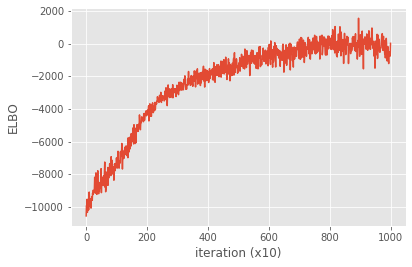

In [12]:
plot_loss(logger)

/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  """
/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


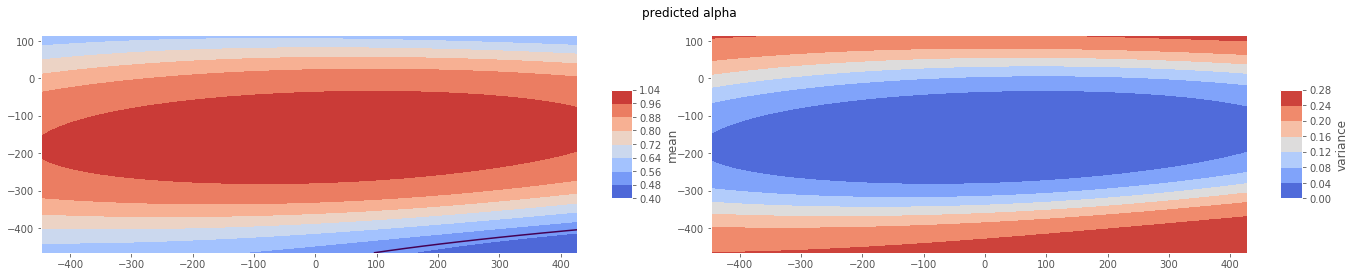

In [20]:
plot_model2D_uav(m, a=True) # plot learned and true separation GP (alpha)
# plt.savefig('img/learned_alpha_2d.pdf', transparent=True)

/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  """


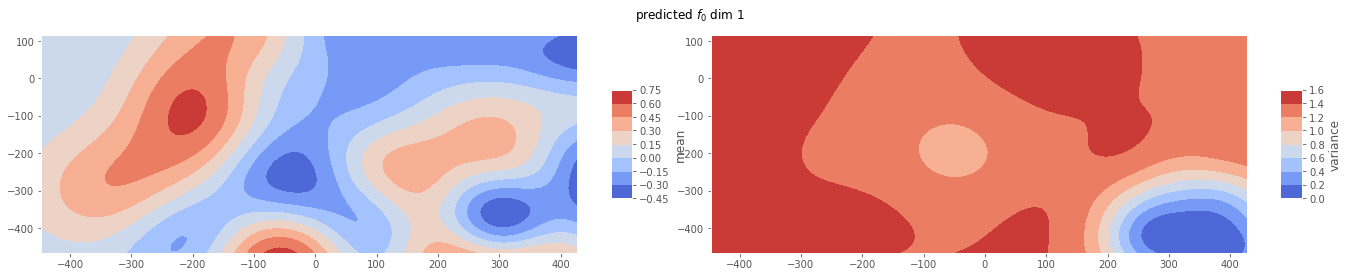

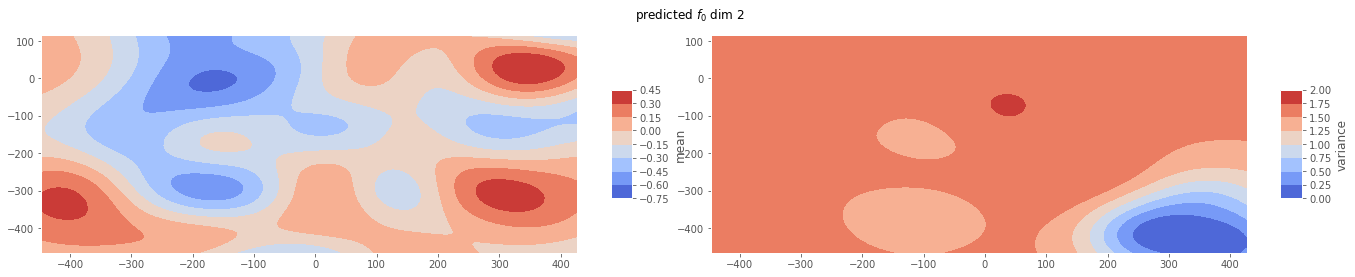

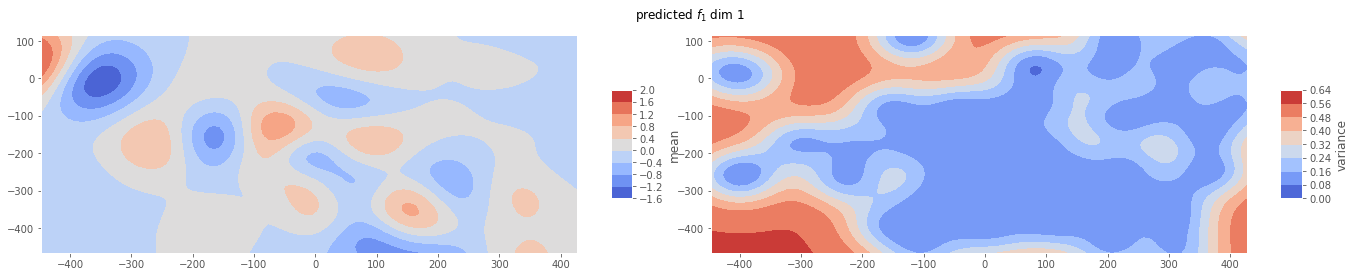

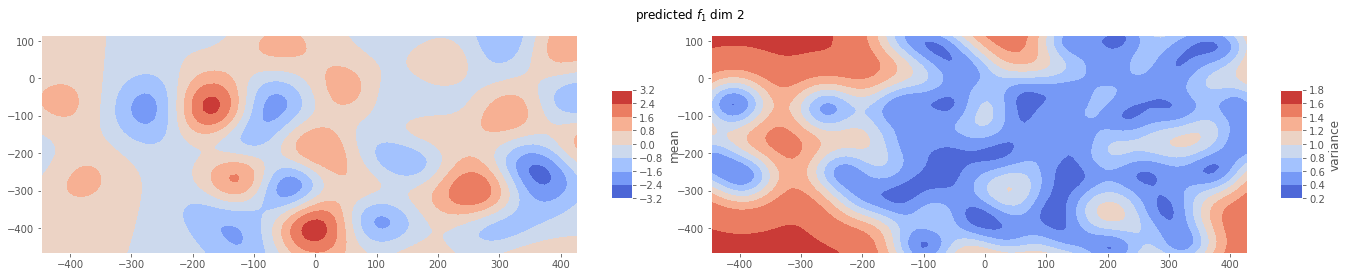

In [21]:
plot_model2D_uav(m, f=True) # plot learned dynamics GPs (2 for each if the 2 dimensions)

(10000, 2)


/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  """


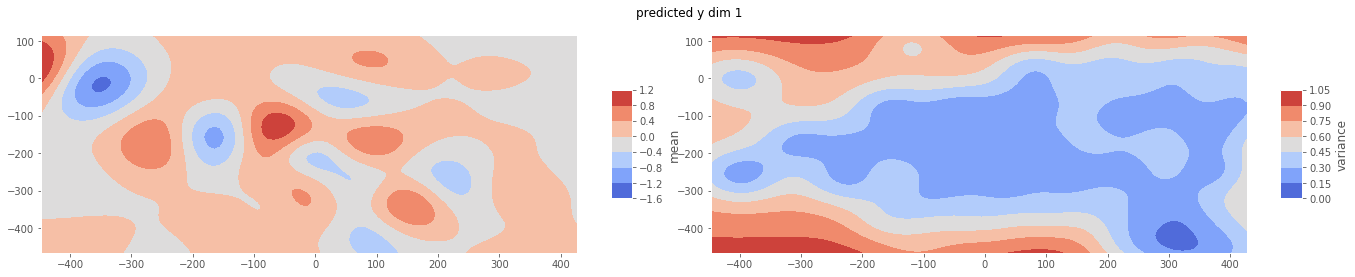

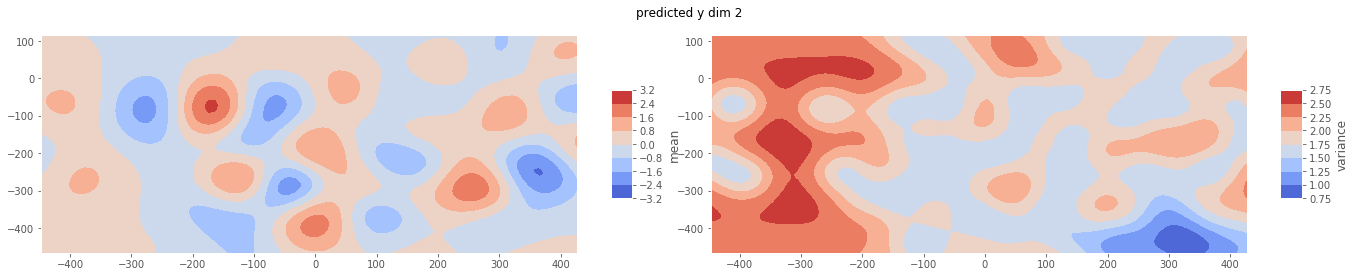

In [22]:
plot_model2D_uav(m, y=True)
# plot_model2D?

In [23]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BMNSVGP/feature_h/Z,Parameter,None,(none),False,"(50, 2)",True,"[[-0.31435180268979745, -1.3736902706504015], ..."
BMNSVGP/features/0/feat_list/0/Z,Parameter,None,(none),False,"(50, 2)",True,"[[1.899339421198308, -0.4071389944345939], [0...."
BMNSVGP/features/0/feat_list/1/Z,Parameter,None,(none),False,"(50, 2)",True,"[[1.1147270590200156, -1.380473369429715], [-0..."
BMNSVGP/features/1/feat_list/0/Z,Parameter,None,(none),False,"(50, 2)",True,"[[1.1674222766789495, 0.7323282745531877], [0...."
BMNSVGP/features/1/feat_list/1/Z,Parameter,None,(none),False,"(50, 2)",True,"[[1.2143015916321678, -0.19564969509582816], [..."
BMNSVGP/kern_h/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[2.337162602050943, 0.5750637916319191]"
BMNSVGP/kern_h/variance,Parameter,None,+ve,True,(),True,0.08094810630205775
BMNSVGP/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[0.40874318769486195, 0.4962889091544891]"
BMNSVGP/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,1.4006556709511802
BMNSVGP/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[0.46953256318632614, 0.4234438283202053]"


In [17]:
# session = gpflow.get_default_session()
# pa = session.run(m.p_a_0_tensor)
# # print(pa)
# plt.scatter(m.X, pa)

In [18]:
# saver = gpflow.saver.Saver()
# saver.save('saved_models/joint_inference', m)